In [1]:
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import sklearn
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa
import os

import scipy
import neurokit2 as nk

import tqdm 


from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline




import statsmodels
import statsmodels.regression.linear_model as sm

plt.rcParams['figure.figsize'] = [15, 9]

import math

In [3]:
lstPIds = []
path = "./final test data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)

[201, 202, 203, 204]


In [4]:
lstAll = []
for pid in tqdm.tqdm(lstPIds):
    
    dfState = pd.read_csv(f"{path}ID{pid}-state.csv")

    dfStart = dfState[dfState.State == "start"].copy()
    dfEnd = dfState[dfState.State == "end"][["Time"]].iloc[:len(dfStart)]
    dfStart = dfStart.rename(columns={"Time":"TimeStart"})
    dfStart.TimeStart = dfStart.TimeStart #+ 60
    dfStart["TimeEnd"] = dfEnd.Time.values
    del dfStart["State"]
    dfStart["Duration"] = dfStart.TimeEnd - dfStart.TimeStart
    df = dfStart[dfStart.BlockNumber != -2].copy()

    dfNBack = pd.read_csv(f"{path}ID{pid}-feedback.csv")
    dfNBack = dfNBack[dfNBack.Time != "Time"]
    correct= (dfNBack["IsCorrect"]==True).count()

    lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time < e.TimeEnd )]
        if (len(dfX) == 0):
            print("No Data!")
        lstNBack.append(dfX.IsCorrect.mean())
    df["IsCorrect"] = lstNBack

    lstCorrectCount = []
    lstTotalTouchCount = []
    #lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time <= e.TimeEnd )]
        lstCorrectCount.append(len(dfX[dfX.IsCorrect == True]))
        lstTotalTouchCount.append(len(dfX))
    
    dfSphere = pd.read_csv(f"{path}ID{pid}-sphere.csv")
    del dfSphere["Feedback"]
    
    lstMissedCount = []
    for i, e in df.iterrows():
        dfX = dfSphere[(dfSphere.Time > e.TimeStart) & (dfSphere.Time <= e.TimeEnd )].reset_index(drop=True)
        missed = 0
        for i in range(0, len(dfX)-1):
            if ((dfX.iloc[i].Type == "up") & (dfX.iloc[i+1].Type == "down")):
                if(dfX.iloc[i+1].Time-dfX.iloc[i].Time > 4):
                    missed += 1
        lstMissedCount.append(missed)
    
    df["NBackCorrect"] = lstCorrectCount
    df["NBackMissed"] = lstMissedCount
    df["NBackTotal"] = np.array(lstTotalTouchCount) + np.array(lstMissedCount)
    df["NBackAccuracy"] = df["NBackCorrect"]/df["NBackTotal"] * 100
    
    df["NBackTimePerBall"] = df["Duration"] / np.array(lstTotalTouchCount)
    
    
    # Read Flow File
    dfFlow = pd.read_csv(f"{path}ID{pid}-flow.csv")
    dfFlow["TimeNorm"] = dfFlow.Time-dfState.Time.iloc[0]

    # Read Visitor File
    #dfLiams = pd.read_csv(f"{path}ID{pid}-visitor.csv")
    #dfLiams = dfLiams.drop_duplicates(subset=['Name'])
    #dfLiams["TimeNorm"] = dfLiams.Time-dfState.Time.iloc[0]

   ## Calculate Accuracy
    lstLiamData = []
    for i, e in df.iterrows():
        dfX = dfFlow[(dfFlow.Time > e.TimeStart) & (dfFlow.Time < e.TimeEnd )]
       
        if ((len(dfX) == 0)):
            print("No Data! Liams" + str(i))
           
        lstLiamData.append(len(dfX))
        
    #lstLiamClickData.append([total, truePositive, falsePositive, trueNegatives, falseNegatives])
    #lstLiamClickData = np.array(lstLiamClickData)
    df["LiamsCountTotal"] = lstLiamData
    #df["LiamsCounTruePositive"] = lstLiamClickData[:,1]
    #df["LiamsCountFalsePositive"] = lstLiamClickData[:,2]
    #df["LiamsCountTrueNegatives"] = lstLiamClickData[:,3]
    #df["LiamsCountFalseNegatives"] = lstLiamClickData[:,4]

   # df["Accuracy"] = (df.LiamsCounTruePositive +  df.LiamsCountTrueNegatives) / df.LiamsCountTotal
    df["Flow"] = df["LiamsCountTotal"] / df.Duration * 60
    
    
    # Read ECG
    dfECG = pd.read_csv(f"{path}ID{pid}-ECG.csv")
    #if(len(dfECG[(dfECG.Value > 3000) | (dfECG.Value < -3000)]) > 0):
    #    print("ECG removed for", pid, "count:",  len(dfECG[(dfECG.Value > 3000) | (dfECG.Value < -3000)]))
    #    dfECG = dfECG[(dfECG.Value < 3000) & (dfECG.Value > -3000)]
        
    
    
    if (len(dfECG) > 0):
        
        dfECG["Clean"] = nk.ecg_clean(dfECG["Value"].values, sampling_rate=130,  method="neurokit") #biosppy
        lstECGMean = []
        lstECGRateValues = []
        lstECGSTD = []
        lsthrv_RMSSD = []
        lsthrv_freq =[]
        #lstEDARel = []
        for i,e in df.iterrows():
            dfECGX = dfECG[(dfECG.Time > e.TimeStart) & (dfECG.Time <= e.TimeEnd )].copy()
            
            if (len(dfECGX) > 0):
                #dfECGProcessed, infoX = nk.bio_process(ecg=dfX["Clean"].values, sampling_rate=130)
                peaks, info = nk.ecg_peaks(dfECGX["Clean"].values, sampling_rate=130, method="kalidas2017", correct_artifacts=True)
                hrv_time = nk.hrv_time(peaks, sampling_rate=130, show=False)
                hrv_freq = nk.hrv_frequency(peaks, sampling_rate=130, show=False, silent=False, psd_method="lomb") #welch
                
                dfECGX["Rate"] = nk.ecg_rate(peaks, sampling_rate=130, interpolation_method="cubic", desired_length=len(dfECGX["Clean"].values))
                
                lstECGRateValues.append(dfECGX.set_index("Time")["Rate"])
                lstECGMean.append(dfECGX["Rate"].mean())
                lstECGSTD.append(dfECGX["Rate"].std())
                lsthrv_RMSSD.append(hrv_time.HRV_RMSSD.iloc[0])
                lsthrv_freq.append(hrv_freq)
            else:
                lstECGRateValues.append(np.nan)
                lstECGMean.append(np.nan)
                lstECGSTD.append(np.nan)
                lsthrv_RMSSD.append(np.nan)
                lsthrv_freq.append(np.nan)

        df["ECGRateValues"] = lstECGRateValues
        df["ECGMean"] = lstECGMean
        df["ECGStd"] = lstECGSTD
        df["ECG_RMSSD"] = lsthrv_RMSSD
        df["ECG_freq"] = lsthrv_freq
    else:
        df["ECGRateValues"] = np.nan
        df["ECGMean"] = np.nan
        df["ECGStd"] = np.nan
        df["ECG_RMSSD"] = np.nan 
        df["ECG_freq"] = np.nan
        
   # Read EDA
    dfEDA = pd.read_csv(f"{path}ID{pid}-EDA.csv")
    edaFs = 250  # Sampling frequency

    dfEDA.Value = (dfEDA.Value / 1000) / 25
    dfEDA["TimeNorm"] = dfEDA.Time-dfState.Time.iloc[0]
    dfEDA["EDAClean"] =  nk.eda_clean(dfEDA["Value"], sampling_rate=edaFs) #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
    #sos = scipy.signal.butter(1, 0.01, btype='lowpass', analog=False, output='sos', fs=edaFs)
    #dfEDA["EDAButter"] = scipy.signal.sosfilt(sos, dfEDA["EDAMedian"])
    #signal, info=nk.eda_process(nk.standardize(dfEDA.EDAClean, sampling_rate=edaFs), sampling_rate=edaFs)
    #signal2, info = nk.eda_sympathetic(dfEDA.EDAClean, sampling_rate=edaFs, frequency_band=[0.045, 0.25], method='posada', show=False)
    signal, info=nk.eda_process(dfEDA.EDAClean, sampling_rate=edaFs)
    dfEDA["EDARaw"] = signal.EDA_Raw
    dfEDA["EDATonic"] = signal.EDA_Tonic
    dfEDA["EDAPhasic"] = signal.EDA_Phasic
    #dfEDA["EDASCR"] = signal.SCR_Amplitude
    #dfEDA["EDASymp"] = signal2.EDA_Symp
    
    
    lstEDATonic = []
    lstEDARaw = []
    lstEDAMedian = []
    lstEDAButter = []
    lstEDAPhasic = []
    #lstEDASCR = []
    #lstEDAFre = []
    
    for i, e in df.iterrows():
        dfX = dfEDA[(dfEDA.Time > e.TimeStart) & (dfEDA.Time < e.TimeEnd )]
        lstEDATonic.append(dfX.EDATonic.mean())
        lstEDARaw.append(dfX.EDARaw.mean())
        lstEDAPhasic.append(dfX.EDAPhasic.mean())
        #lstEDASCR.append(dfX.EDASCR.mean())
        #lstEDAFre.append(dfX.EDAFre.mean())
        #lstEDAMedian.append(dfX.EDAClean.mean())
        #lstEDAButter.append(dfX.EDAButter.mean())

    df["EDATonic"] = lstEDATonic
    df["EDARaw"] = lstEDARaw
    df["EDAPhasic"] = lstEDAPhasic
    #df["EDASCR"] = lstEDASCR
    #df["EDAClean"] = lstEDAClean
    #df["EDAButter"] = lstEDAButter
   # dfEDA["EDASymp"] = lstEDASymp
    df["PId"] = pid
    lstAll.append(df)
    
dfAll = pd.concat(lstAll)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.36s/it]


In [5]:
lstAll = []
for pid in tqdm.tqdm(lstPIds):
    
    dfState = pd.read_csv(f"{path}ID{pid}-state.csv")

    dfStart = dfState[dfState.State == "start"].copy()
    dfEnd = dfState[dfState.State == "end"][["Time"]].iloc[:len(dfStart)]
    dfStart = dfStart.rename(columns={"Time":"TimeStart"})
    dfStart.TimeStart = dfStart.TimeStart #+ 60
    dfStart["TimeEnd"] = dfEnd.Time.values
    del dfStart["State"]
    dfStart["Duration"] = dfStart.TimeEnd - dfStart.TimeStart
    df = dfStart[dfStart.BlockNumber != -2].copy()

    dfNBack = pd.read_csv(f"{path}ID{pid}-feedback.csv")
    dfNBack = dfNBack[dfNBack.Time != "Time"]
    correct= (dfNBack["IsCorrect"]==True).count()

    lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time < e.TimeEnd )]
        if (len(dfX) == 0):
            print("No Data!")
        lstNBack.append(dfX.IsCorrect.mean())
    df["IsCorrect"] = lstNBack

    lstCorrectCount = []
    lstTotalTouchCount = []
    #lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time <= e.TimeEnd )]
        lstCorrectCount.append(len(dfX[dfX.IsCorrect == True]))
        lstTotalTouchCount.append(len(dfX))
    
    dfSphere = pd.read_csv(f"{path}ID{pid}-sphere.csv")
    del dfSphere["Feedback"]
    
    lstMissedCount = []
    for i, e in df.iterrows():
        dfX = dfSphere[(dfSphere.Time > e.TimeStart) & (dfSphere.Time <= e.TimeEnd )].reset_index(drop=True)
        missed = 0
        for i in range(0, len(dfX)-1):
            if ((dfX.iloc[i].Type == "up") & (dfX.iloc[i+1].Type == "down")):
                if(dfX.iloc[i+1].Time-dfX.iloc[i].Time > 4):
                    missed += 1
        lstMissedCount.append(missed)
    
    df["NBackCorrect"] = lstCorrectCount
    df["NBackMissed"] = lstMissedCount
    df["NBackTotal"] = np.array(lstTotalTouchCount) + np.array(lstMissedCount)
    df["NBackAccuracy"] = df["NBackCorrect"]/df["NBackTotal"] * 100
    
    df["NBackTimePerBall"] = df["Duration"] / np.array(lstTotalTouchCount)
    
    
    # Read Flow File
    dfFlow = pd.read_csv(f"{path}ID{pid}-flow.csv")
    dfFlow["TimeNorm"] = dfFlow.Time-dfState.Time.iloc[0]

    # Read Visitor File
    #dfLiams = pd.read_csv(f"{path}ID{pid}-visitor.csv")
    #dfLiams = dfLiams.drop_duplicates(subset=['Name'])
    #dfLiams["TimeNorm"] = dfLiams.Time-dfState.Time.iloc[0]

   ## Calculate Accuracy
    lstLiamData = []
    for i, e in df.iterrows():
        dfX = dfFlow[(dfFlow.Time > e.TimeStart) & (dfFlow.Time < e.TimeEnd )]
       
        if ((len(dfX) == 0)):
            print("No Data! Liams" + str(i))
           
        lstLiamData.append(len(dfX))
        
    #lstLiamClickData.append([total, truePositive, falsePositive, trueNegatives, falseNegatives])
    #lstLiamClickData = np.array(lstLiamClickData)
    df["LiamsCountTotal"] = lstLiamData
    #df["LiamsCounTruePositive"] = lstLiamClickData[:,1]
    #df["LiamsCountFalsePositive"] = lstLiamClickData[:,2]
    #df["LiamsCountTrueNegatives"] = lstLiamClickData[:,3]
    #df["LiamsCountFalseNegatives"] = lstLiamClickData[:,4]

   # df["Accuracy"] = (df.LiamsCounTruePositive +  df.LiamsCountTrueNegatives) / df.LiamsCountTotal
    df["Flow"] = df["LiamsCountTotal"] / df.Duration * 60
    
    
    # Read ECG
    dfECG = pd.read_csv(f"{path}ID{pid}-ECG.csv")
    #if(len(dfECG[(dfECG.Value > 3000) | (dfECG.Value < -3000)]) > 0):
    #    print("ECG removed for", pid, "count:",  len(dfECG[(dfECG.Value > 3000) | (dfECG.Value < -3000)]))
    #    dfECG = dfECG[(dfECG.Value < 3000) & (dfECG.Value > -3000)]
        
    
    
    if (len(dfECG) > 0):
        
        dfECG["Clean"] = nk.ecg_clean(dfECG["Value"].values, sampling_rate=130,  method="neurokit") #biosppy
        lstECGMean = []
        lstECGRateValues = []
        #lstECGSTD = []
        lsthrv_RMSSD = []
        #lsthrv_freq =[]
        lsthrv_HRV_SDNN = []
        #lstEDARel = []
        for i,e in df.iterrows():
            dfECGX = dfECG[(dfECG.Time > e.TimeStart) & (dfECG.Time <= e.TimeEnd )].copy()
            
            if (len(dfECGX) > 0):
                #dfECGProcessed, infoX = nk.bio_process(ecg=dfX["Clean"].values, sampling_rate=130)
                peaks, info = nk.ecg_peaks(dfECGX["Clean"].values, sampling_rate=130, method="kalidas2017", correct_artifacts=True)
                hrv_time = nk.hrv_time(peaks, sampling_rate=130, show=False)
                #hrv_freq = nk.hrv_frequency(peaks, sampling_rate=130, show=False, silent=False, psd_method="lomb") #welch
                
                dfECGX["Rate"] = nk.ecg_rate(peaks, sampling_rate=130, interpolation_method="cubic", desired_length=len(dfECGX["Clean"].values))
                
                lstECGRateValues.append(dfECGX.set_index("Time")["Rate"])
                lstECGMean.append(dfECGX["Rate"].mean())
                #lstECGSTD.append(dfECGX["Rate"].std())
                lsthrv_RMSSD.append(hrv_time.HRV_RMSSD.iloc[0]) 
                lsthrv_HRV_SDNN.append(hrv_time.HRV_SDNN.iloc[0])
                #lsthrv_freq.append(hrv_freq)
            else:
                lstECGRateValues.append(np.nan)
                lstECGMean.append(np.nan)
                #lstECGSTD.append(np.nan)
                lsthrv_RMSSD.append(np.nan)
                lsthrv_HRV_SDNN.append(np.nan)
                #lsthrv_freq.append(np.nan)

        df["ECGRateValues"] = lstECGRateValues
        df["ECGMean"] = lstECGMean
        #df["ECGStd"] = lstECGSTD
        df["ECG_RMSSD"] = lsthrv_RMSSD
        df["HRV_SDNN"] = lsthrv_HRV_SDNN
        #df["ECG_freq"] = lsthrv_freq
    else:
        df["ECGRateValues"] = np.nan
        df["ECGMean"] = np.nan
        #df["ECGStd"] = np.nan
        df["ECG_RMSSD"] = np.nan 
        df["HRV_SDNN"] = np.nan
        #df["ECG_freq"] = np.nan
        
   # Read EDA
    dfEDA = pd.read_csv(f"{path}ID{pid}-EDA.csv")
    edaFs = 250  # Sampling frequency

    dfEDA.Value = (dfEDA.Value / 1000) / 25
    dfEDA["TimeNorm"] = dfEDA.Time-dfState.Time.iloc[0]
    dfEDA["EDAClean"] =  nk.eda_clean(dfEDA["Value"], sampling_rate=edaFs) #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
    #sos = scipy.signal.butter(1, 0.01, btype='lowpass', analog=False, output='sos', fs=edaFs)
    #dfEDA["EDAButter"] = scipy.signal.sosfilt(sos, dfEDA["EDAMedian"])
    #signal, info=nk.eda_process(nk.standardize(dfEDA.EDAClean, sampling_rate=edaFs), sampling_rate=edaFs)
    #signal2, info = nk.eda_sympathetic(dfEDA.EDAClean, sampling_rate=edaFs, frequency_band=[0.045, 0.25], method='posada', show=False)
    signal, info=nk.eda_process(dfEDA.EDAClean, sampling_rate=edaFs)
    dfEDA["EDARaw"] = signal.EDA_Raw
    dfEDA["EDATonic"] = signal.EDA_Tonic
    dfEDA["EDAPhasic"] = signal.EDA_Phasic
    #dfEDA["EDASCR"] = signal.SCR_Amplitude
    #dfEDA["EDASymp"] = signal2.EDA_Symp
    
    
    lstEDATonic = []
    lstEDARaw = []
    lstEDAMedian = []
    lstEDAButter = []
    lstEDAPhasic = []
    #lstEDASCR = []
    #lstEDAFre = []
    
    for i, e in df.iterrows():
        dfX = dfEDA[(dfEDA.Time > e.TimeStart) & (dfEDA.Time < e.TimeEnd )]
        lstEDATonic.append(dfX.EDATonic.mean())
        lstEDARaw.append(dfX.EDARaw.mean())
        lstEDAPhasic.append(dfX.EDAPhasic.mean())
        #lstEDASCR.append(dfX.EDASCR.mean())
        #lstEDAFre.append(dfX.EDAFre.mean())
        #lstEDAMedian.append(dfX.EDAClean.mean())
        #lstEDAButter.append(dfX.EDAButter.mean())

    df["EDATonic"] = lstEDATonic
    df["EDARaw"] = lstEDARaw
    df["EDAPhasic"] = lstEDAPhasic
    #df["EDASCR"] = lstEDASCR
    #df["EDAClean"] = lstEDAClean
    #df["EDAButter"] = lstEDAButter
   # dfEDA["EDASymp"] = lstEDASymp
    df["PId"] = pid
    lstAll.append(df)
    
dfAll = pd.concat(lstAll)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.99s/it]


In [6]:
list(dfAll.columns)

['TimeStart',
 'BlockNumber',
 'AdaptationStatus',
 'NBackN',
 'TimeEnd',
 'Duration',
 'IsCorrect',
 'NBackCorrect',
 'NBackMissed',
 'NBackTotal',
 'NBackAccuracy',
 'NBackTimePerBall',
 'LiamsCountTotal',
 'Flow',
 'ECGRateValues',
 'ECGMean',
 'ECG_RMSSD',
 'HRV_SDNN',
 'EDATonic',
 'EDARaw',
 'EDAPhasic',
 'PId']

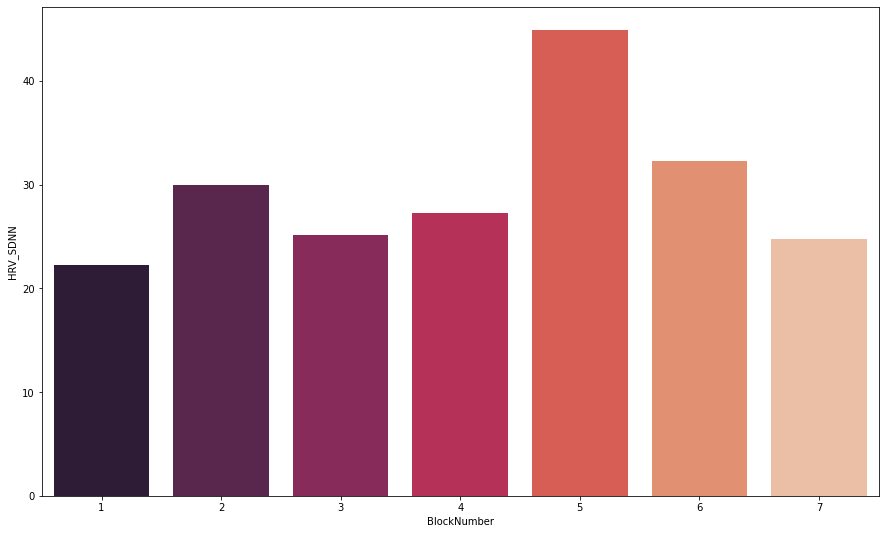

In [7]:
f = sns.barplot(x=df['BlockNumber'], y=df['HRV_SDNN'], palette="rocket")
